In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the stock symbol and the period of investment
stock_symbol = 'MSFT'
period_years = 30
start_date = '1993-01-01'
end_date = '2023-01-01'

# Download historical data for the stock
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)

# Generate monthly dates - first trading day of each month
monthly_dates = stock_data.resample('MS').first().index

# Ensure every date in monthly_dates is in stock_data index
monthly_dates = [date for date in monthly_dates if date in stock_data.index]

In [3]:
# Buy and Hold Strategy
investment_per_month = 1000
total_shares = 0  
# List to store growth values
buy_and_hold_growth = []  

for date in monthly_dates:
    shares_bought = investment_per_month / stock_data.loc[date, 'Adj Close']
    total_shares += shares_bought
    current_value = total_shares * stock_data.loc[date, 'Adj Close']
    buy_and_hold_growth.append(current_value)

In [4]:
# Active Trading Strategy
sma_short_window = 50
sma_long_window = 200

stock_data['SMA_Short'] = stock_data['Adj Close'].rolling(window=sma_short_window, min_periods=1).mean()
stock_data['SMA_Long'] = stock_data['Adj Close'].rolling(window=sma_long_window, min_periods=1).mean()

stock_data['Signal'] = 0
stock_data.loc[stock_data.index[sma_short_window:], 'Signal'] = np.where(stock_data['SMA_Short'][stock_data.index[sma_short_window:]] > stock_data['SMA_Long'][stock_data.index[sma_short_window:]], 1, 0)
stock_data['Position'] = stock_data['Signal'].diff()

active_trading_equity = 0
savings = 0
# List to store growth values
active_trading_growth = []  

for date in monthly_dates:
    if date not in stock_data.index:
        active_trading_growth.append(active_trading_equity * stock_data.iloc[-1]['Adj Close'] + savings)
        continue

    if stock_data.loc[date, 'Signal'] == 1:
        active_trading_equity += investment_per_month / stock_data.loc[date, 'Adj Close']
    else:
        savings += investment_per_month

    if stock_data.loc[date, 'Position'] == -1:
        savings += active_trading_equity * stock_data.loc[date, 'Adj Close']
        active_trading_equity = 0

    if stock_data.loc[date, 'Position'] == 1 and savings > 0:
        active_trading_equity += savings / stock_data.loc[date, 'Adj Close']
        savings = 0

    current_value = (active_trading_equity * stock_data.loc[date, 'Adj Close']) + savings
    active_trading_growth.append(current_value)

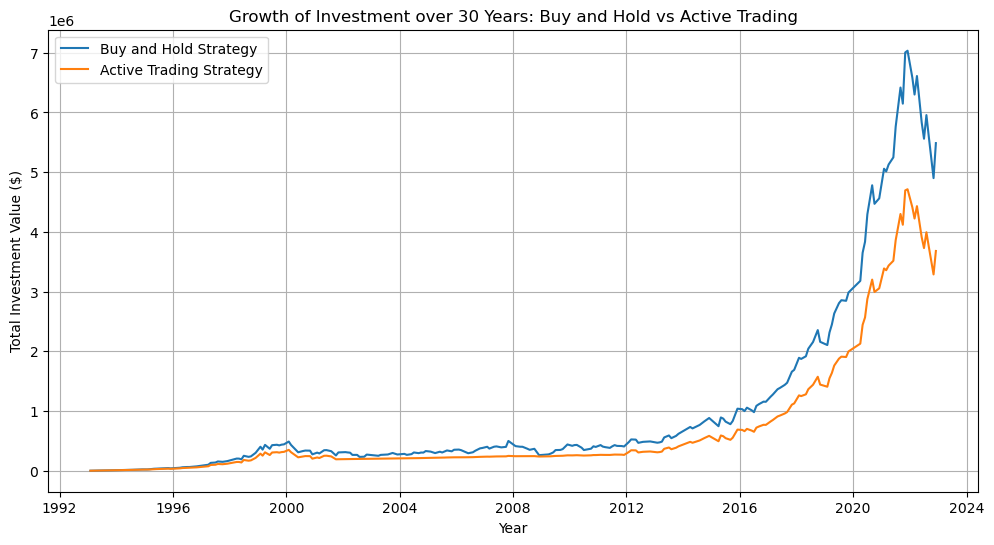

In [5]:
# Plotting the growth of money using both strategies
plt.figure(figsize=(12, 6))
plt.title("Growth of Investment over 30 Years: Buy and Hold vs Active Trading")

plt.plot(monthly_dates, buy_and_hold_growth, label='Buy and Hold Strategy')
plt.plot(monthly_dates, active_trading_growth, label='Active Trading Strategy')

plt.xlabel('Year')
plt.ylabel('Total Investment Value ($)')
plt.legend()
plt.grid(True)
plt.show()

buy_and_hold_final_equity = total_shares * stock_data.iloc[-1]['Adj Close']

active_trading_equity = 0
savings = 0

for date in monthly_dates:
    if date not in stock_data.index:
        # Skip dates not in the data
        continue  

    if stock_data.loc[date, 'Signal'] == 1:
        # Buy stock
        active_trading_equity += investment_per_month / stock_data.loc[date, 'Adj Close']
    else:
        # Save money
        savings += investment_per_month

    # Check if we need to sell all stocks and move to savings
    if stock_data.loc[date, 'Position'] == -1:
        savings += active_trading_equity * stock_data.loc[date, 'Adj Close']
        active_trading_equity = 0

    # Check if we need to buy stocks with all savings
    if stock_data.loc[date, 'Position'] == 1 and savings > 0:
        active_trading_equity += savings / stock_data.loc[date, 'Adj Close']
        savings = 0

In [6]:
# Final equity value for Active Trading
active_trading_final_equity = (active_trading_equity * stock_data.iloc[-1]['Adj Close']) + savings

years_investment = period_years
buy_and_hold_annual_return = ((buy_and_hold_final_equity / (investment_per_month * 12 * years_investment)) ** (1 / years_investment) - 1) * 100
active_trading_annual_return = ((active_trading_final_equity / (investment_per_month * 12 * years_investment)) ** (1 / years_investment) - 1) * 100

print("Buy and Hold Strategy:")
print(f"Total Equity: ${buy_and_hold_final_equity:.2f}")
print(f"Annual Percent Return: {buy_and_hold_annual_return:.2f}%")

print("\nActive Trading Strategy:")
print(f"Total Equity: ${active_trading_final_equity:.2f}")
print(f"Annual Percent Return: {active_trading_annual_return:.2f}%")

Buy and Hold Strategy:
Total Equity: $5166815.67
Annual Percent Return: 9.29%

Active Trading Strategy:
Total Equity: $3466604.00
Annual Percent Return: 7.84%


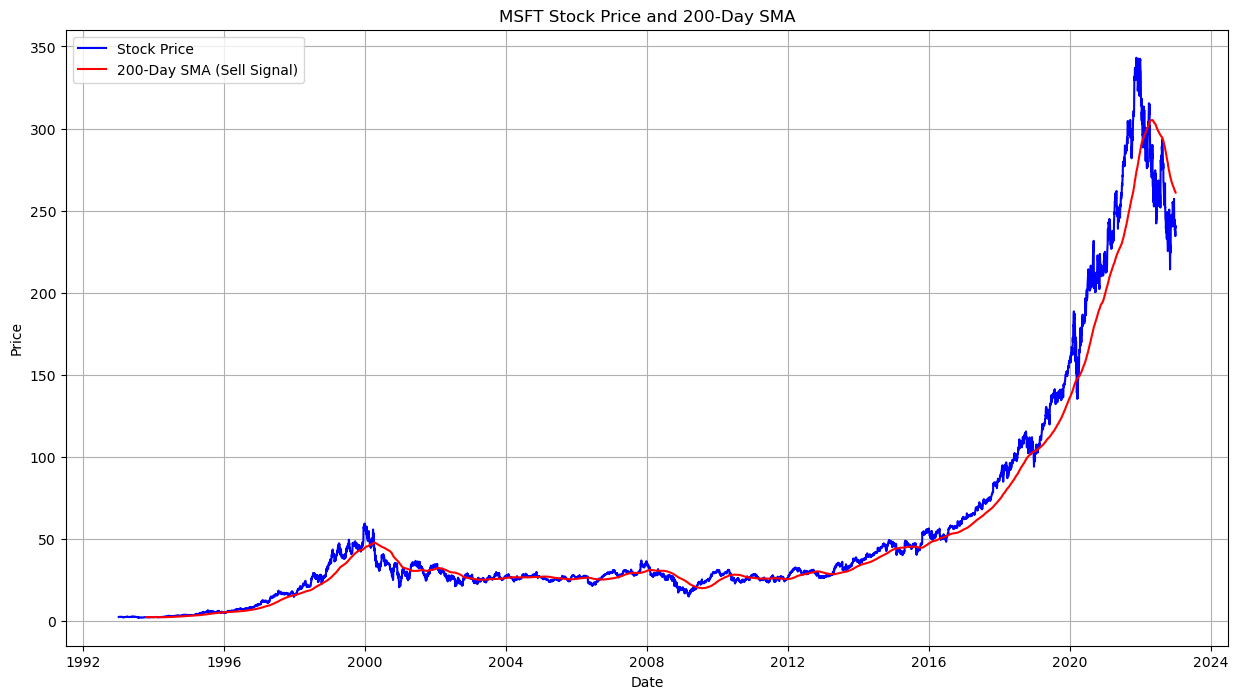

In [7]:
# graph stock price w SMA 
sma_period = 200
stock_data['SMA'] = stock_data['Close'].rolling(window=sma_period).mean()

# Plot the stock price and the SMA
plt.figure(figsize=(15, 8))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', color='blue')
plt.plot(stock_data.index, stock_data['SMA'], label='200-Day SMA (Sell Signal)', color='red')

plt.title(f'{stock_symbol} Stock Price and 200-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()